# Data Science Lab 2
## Emily Chang (*echang39*) & Marion Pang (*mpangwa1*)

# Classification of cardiomyocites based on their action potentials
In this lab experience we will be looking at the problem of classifying cardiac cells by looking at
their _Action Potentials_ (APs). For the purpose of this task we will be using synthetically
generated APs following the models in [(Nygren et. al, 1998)](https://www.ahajournals.org/doi/abs/10.1161/01.res.82.1.63) and [(O'Hara et. al, 2011)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002061).

### Objectives
By the end of this session you should be able to use nearest-neighbor and simple neural network classifiers for two-class classification problems.

* _Note: Everything below this line should be truned in as part of your lab report._


In [1]:
# ============================================================================
# import modules
# ============================================================================
# Note that this part of the code needs to be run prior to any other code cell

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import random as rnd
import torch

# inline plots
%matplotlib inline

# set random number generator seed
rnd.seed(10)

# mount GDrive
from google.colab import drive
drive.mount('gdrive/')

# ============================================================================
# data loading
# ============================================================================

# PLEASE, SPECIFY YOUR PATH TO THE DATA HERE
datapath = 'gdrive/My Drive/bmdslab/lab-02/'

# get the list of files to process
matfile = '/'.join((datapath,'Adult_samples.mat'))

# get data as dictionary
adata = scipy.io.loadmat(matfile)

# see the keys of the dictionary 'Vatrial' and 'Vventricular'
# adata['Vatrial'] contains action potentials of cardiac cells of atrial type
# adata['Vventricular'] contains action potentials of cardiac cells of ventricular type
adata.keys()


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at gdrive/


dict_keys(['__header__', '__version__', '__globals__', 'Vatrial', 'Vventricular'])

(347, 1000)


Text(0.5, 0, 'Time')

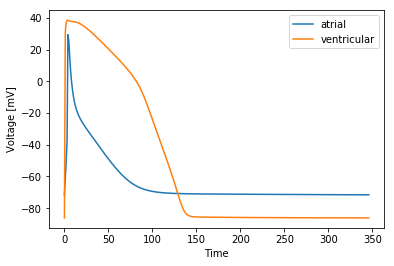

In [2]:
# look at the data dimensions
print(adata['Vatrial'].shape)

# let's see how the data looks like
plt.plot(adata['Vatrial'][:,0])
plt.plot(adata['Vventricular'][:,0])
plt.legend(('atrial','ventricular'))
plt.ylabel('Voltage [mV]')
plt.xlabel('Time')

### Task 1. Pre-processing and manual feature extraction
In this first part we will be normalizing the data and extracting hand-crafted features that will be later
used for the classification task. Load the dataset **Adult_samples.mat** that contains examples of
adult atrial and ventricular action potentials generated using the models in [(Nygren et al., 1998)](https://www.ahajournals.org/doi/abs/10.1161/01.res.82.1.63) and [(O'Hara et al., 2011)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002061).
For each of the two classes there are $1000$ samples generated with a sampling rate of $f_s=500$ Hz.

* _(15 points) Data preparation and normalization._
Split the data between test and training sets by
randomly selecting $10\%$ of the points as your training set. Make sure the two classes are well represented
in the training set (e.g., use the same number for both). Normalize the data so that each AP has zero resting potential and unit maximum amplitude. Create an array of corresponding labels for the data points. For ventricular type use the class label $+1$ and $-1$ for
atrial type.
Make two plots displaying your normalized training data for each of the classes. Use time units for the horizontal axis.

Text(0.5, 1.0, 'Training Ventricular Data')

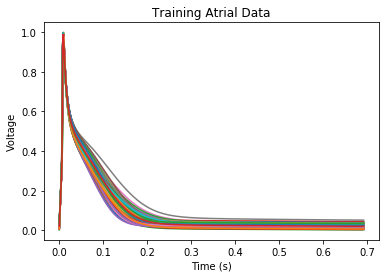

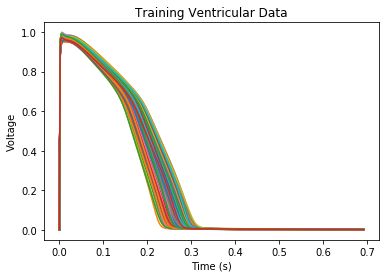

In [3]:
# normalize data first, making min=0 and max =1
def normalize_range(x):
    if np.any(x):
        minx = np.min(x)
        z = x - minx
        maxz = np.max(z)
        return z/maxz    
    else:
        return x
        
vatrial = normalize_range(adata['Vatrial'])
vventricular = normalize_range(adata['Vventricular'])

# each has 1000 samples, with 347 time points
# hold out 10% for training
trainFraction = .10
sample = np.random.uniform(size = 1000) < trainFraction

xAtraining = vatrial[:,sample]
xAtesting = vatrial[:,~sample]
xVtraining = vventricular[:,sample]
xVtesting = vventricular[:,~sample]

xtrain = np.concatenate((xAtraining, xVtraining),axis=1)
xtest = np.concatenate((xAtesting, xVtesting), axis=1)

# make labels (+1 for ventricular, -1 for atrial)
ytrain = np.zeros(sum(sample)*2)
ytest = np.zeros(2000-(sum(sample))*2)

ytrain[0:sum(sample)]=-1
ytrain[sum(sample):]=1
ytest[0:sum(~sample)]=-1
ytest[sum(~sample):]=1

# display normalized training data for each class
# making array for x time axis
time = np.arange(0,adata['Vatrial'].shape[0]*1/500,1/500)

aindice = np.where(ytrain == -1)[0]
vindice = np.where(ytrain == 1)[0]

plt.figure()
plt.plot(time, xtrain[:,aindice])
plt.xlabel("Time (s)")
plt.ylabel("Voltage")
plt.title("Training Atrial Data")

plt.figure()
plt.plot(time, xtrain[:,vindice])
plt.xlabel("Time (s)")
plt.ylabel("Voltage")
plt.title("Training Ventricular Data")

* _(20 points) Hand-crafted features._
The _Action Potential Duration_ (APD) at $x\%$ is defined as the time
it takes to reduce the maximum amplitude of the AP to $x\%$ of its value. Write a function that computes APD at a given
percentage $x\in[0,1]$. Compute also the _Average of the Action Potential_ (AAP) and build two-dimensional features
by concatenating APD@$0.5$ and AAP. Make a scatter plot of the training data using these two features. Use
different colors and/or markers to represent each class.

    * Based on your scatter plot, is the training data using the above features linearly separable? Why?

Text(0.5, 1.0, 'APD vs AAP of Atrial and Ventricular cells')

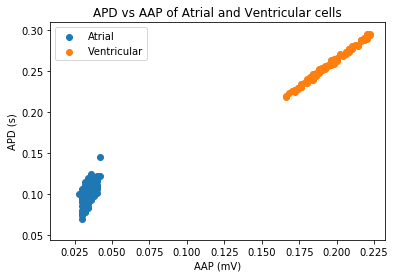

In [4]:
# ============================================================================
# compute hand-crafted features such as APA and APDx
# ============================================================================

def apdx(X,alpha=0.5,fs=1.0):
    """
    This function computes the APDx feature defined as the time it takes to
    reduce the action potential to x% of its maximum value.
    Use:
        APD = apdx(X,alpha,fs)
        
    Inputs:
        X : data points (each column is a data point)
        alpha : [0,1] percentage of maximum amplitude
        fs : sampling frequency (to map samples to time)
    Output:
        APD feature
    """
    # account for rise at the start
    i=np.where(X == np.max(X))[0]; Vcur=X[i]

    while(Vcur > alpha):
      i=i+1
      Vcur=X[i]

    time = i*1/fs
    return time[0]

# make function that returns [APD, AAP]
def featureReturn(set):
  return [apdx(set,0.5,500),np.mean(set)]

# make features array with [APD, AAP]
feat = []
for i in range(0,xtrain.shape[1]):
  feat.append(featureReturn(xtrain[:,i]))

# make plot of APD against AAP

plt.figure()
plt.scatter([feat[j][0] for j in aindice],[feat[j][1] for j in aindice])
plt.scatter([feat[j][0] for j in vindice],[feat[j][1] for j in vindice])
plt.legend(("Atrial","Ventricular"))
plt.xlabel("AAP (mV)")
plt.ylabel("APD (s)")
plt.title("APD vs AAP of Atrial and Ventricular cells")

# Yes, the classes are easily separable. The ventricular cells have a distinctly higher ratio of APD/AAP compared to the Atrial cells. 

### Task 2. Classification

* _(15 points) Nearest-neighbor classifier._
Implement a $1$NN classifier using the Euclidean distance. A $1$NN classifier works as follows: Given your training dataset $\mathcal{D} = \big\{(\boldsymbol x_i,y_i)\big\}_{i=1}^{N}$,where $N$ is the number of training samples, $\boldsymbol x_i\in\mathbb{R}^D$ is a feature vector and $y_i\in\{-1,1\}$ its associated label, and a novel sample $\boldsymbol x$, the $1$NN classifier assigns to $\boldsymbol x$ the same label as its closest point in the training set. That is, the estimated label $\widehat y$ of $\boldsymbol x$ is such that:

\begin{equation}
	\widehat y(\boldsymbol x) = y_{k^*},\quad k^* = \underset{i\in\{1,\ldots,N\}}{\arg\min}\, \lVert \boldsymbol x_i - \boldsymbol x \rVert_2.
\end{equation}

Compute and display the classification accuracy over the test set using the handcrafted training features of **Task 1**.

In [0]:
# ============================================================================
# Nearest-neighbor classifier
# ============================================================================

def nn_classify(Xtest,Xtrain,ytrain):
    """
    This function implements a nearest neighbor classifier.
    Use:
        yhat = nn_classify(Xtest,Xtrain,ytrain)   
    Inputs:
        Xtest  : test data points (each column is a data point)
        Xtrain : training data points
        ytrain : associated labels to the training data points
        
    Output:
        yhat : estimated labels for the test data.
    """
    # implement your NN classifier below
    yhat=[]
    for i in range(0,Xtest.shape[1]):
      # initalize diff array
      diff = []
      x_feat=featureReturn(Xtest[:,i])

      # calculate diff array across Xtrain
      for j in range(0,Xtrain.shape[1]):
        diff.append(np.subtract(featureReturn(Xtrain[:,j]),x_feat))
      new_y = ytrain[np.argmin(np.sum(np.abs(diff)**2,axis=-1)**(1./2))]
      yhat.append(new_y)
    
    return yhat

yhat_test=nn_classify(xtest,xtrain,ytrain)

In [6]:
sum_test_acc=0

for i in range(0,len(ytest)-1):
  if yhat_test[i]==ytest[i]:
    sum_test_acc=sum_test_acc+1

test_acc=sum_test_acc/len(ytest)

print("The accuracy of the testing set is", test_acc)

The accuracy of the testing set is 0.9994419642857143


* _(40 points) Two-layer Neural Network._
 Implement a two-layer neural network classifier of the form:

   $$\widehat y = \operatorname{sign}\big(f_{\theta}(\phi(\boldsymbol x))\big),\quad f_{\theta}(\phi(\boldsymbol x)) = \boldsymbol w^T\phi(\boldsymbol x) + b,\quad \theta = \left[\begin{array}{c}\boldsymbol w\\b\end{array}\right],$$
  
 where $f_\theta(\cdot)$ is a _linear prediction function_ (i.e., classification layer) parametrized by $\theta = [\boldsymbol w^T, b]^T$. The feature extraction part of the network consists of a linear layer followed by a ReLu (rectified linear unit) non-linearity:
 
 $$ \phi(x) = \operatorname{ReLu}\big(\boldsymbol W_1 \boldsymbol x + \boldsymbol b_1\big),\quad\operatorname{ReLu}(x)=\begin{cases}x &x>0\\0&\textrm{else}\end{cases}.$$
 
 In order to find the network's parameters $\Theta=\{\boldsymbol W_1, \boldsymbol b_1, \boldsymbol w, b\}$ minimize the following _regularized empirical risk_ using PyTorch:

   $$\min_{\Theta}\, \underbrace{\frac{1}{N} \sum_{i=1}^N L\big(f_\theta(\phi(\boldsymbol x_i)),y_i\big) + \lambda\big(\frac{1}{w}\lVert \boldsymbol w\rVert^2 + \frac{1}{W}\lVert\boldsymbol W_1\rVert^2\big)}_{C(\Theta)}$$
    
 where the loss function $L(f, y) = \lVert y-f\rVert_2^2)$ is the quadratic (square) loss, and $w,W$, are the number of elements in $\boldsymbol w$ and $\boldsymbol W$, respectively. 

    * Define a network model in PyTorch according to the definition above. For that purpose you can use `torch.nn.Sequential`. Follow this [example](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-nn) to learn how to use it.
    
    * Run a gradient descent algorithm to minimize the cost function using $\lambda =1$. Carefully choose the stepsize and number of iterations until you see the method converges (i.e., the cost function gets to a "plateau").
    
    * Make a scatter plot of the learned features (i.e., prior to classificaiton layer) by your network model. Has your model learned features that are linearly separable? Display in the scatter plot the decision boundary that you have learned. Compute the classification accuracy over the test set.
    
    * Plot the weights of the learned linear layer. What has your network learned?



/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([208])) that is different to the input size (torch.Size([208, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0 1.2937918901443481 999999999998.7062
1 1.293704867362976 8.702278137207031e-05
2 1.2936174869537354 8.738040924072266e-05
3 1.2935290336608887 8.845329284667969e-05
4 1.2934396266937256 8.940696716308594e-05
5 1.293349027633667 9.059906005859375e-05
6 1.2932581901550293 9.083747863769531e-05
7 1.2931674718856812 9.071826934814453e-05
8 1.2930761575698853 9.131431579589844e-05
9 1.292983055114746 9.310245513916016e-05
10 1.292889952659607 9.310245513916016e-05
11 1.2927968502044678 9.310245513916016e-05
12 1.292703628540039 9.322166442871094e-05
13 1.2926102876663208 9.334087371826172e-05
14 1.2925167083740234 9.357929229736328e-05
15 1.2924234867095947 9.322166442871094e-05
16 1.2923305034637451 9.298324584960938e-05
17 1.292236328125 9.417533874511719e-05
18 1.2921421527862549 9.417533874511719e-05
19 1.2920480966567993 9.40561294555664e-05
20 1.2919543981552124 9.369850158691406e-05
21 1.2918606996536255 9.369850158691406e-05
22 1.29176664352417 9.40561294555664e-05
23 1.2916728258

Text(0, 0.5, 'Iterations')

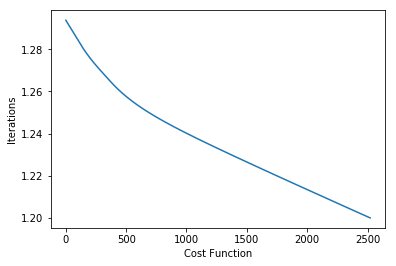

In [7]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = xtrain.shape[1], xtrain.shape[0], 2, 1
lamb = 1; diff = 10000000; old_loss = 1000000000000; t=0; cf = []

# convert x and y to Tensors to hold inputs and outputs
x = torch.from_numpy(xtrain.transpose()).float()
y = torch.from_numpy(ytrain).float()

# Use the nn package to define our model as a sequence of linear, ReLU, and linear
w = torch.nn.Linear(D_in, H); W = torch.nn.Linear(H, D_out); ReLU = torch.nn.ReLU();

model = torch.nn.Sequential(
    w,
    ReLU,
    W,
)

learning_rate = 1e-4
cLoss=2
while cLoss > 1.2:
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute cost function as combination of loss function and 2 weight terms
    loss_fn = torch.nn.MSELoss(reduction='mean')
    loss = loss_fn(y_pred, y) + lamb * (1/torch.numel(W.weight) * torch.norm(W.weight)+1/torch.numel(w.weight) * torch.norm(w.weight))

    # calculate diff in loss
    diff=abs(old_loss-loss.item())

    cf.append(loss.item())
    cLoss=loss.item()
    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    print(t, loss.item(), diff)

    # reset variables
    t=t+1
    old_loss=loss.item()

plt.figure()
plt.plot(cf)
plt.xlabel("Cost Function")
plt.ylabel("Iterations")

torch.Size([1792, 2])


Text(0.5, 1.0, 'ReLU Features')

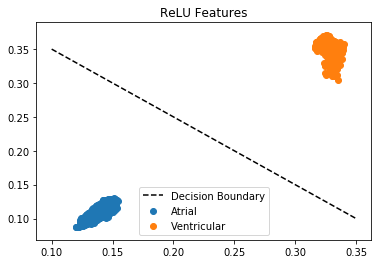

In [53]:
testingX = torch.from_numpy(xtest.transpose()).float()

phi = ReLU(w(testingX))
print(phi.shape)

aTindice = np.where(ytest == -1)[0]
vTindice = np.where(ytest == 1)[0]

modelFeat = phi.detach().numpy()

plt.figure()
plt.plot([0.10,0.35],[0.35,0.10],'k--')
plt.scatter([modelFeat[j][0] for j in aTindice],[modelFeat[j][1] for j in aTindice])
plt.scatter([modelFeat[j][0] for j in vTindice],[modelFeat[j][1] for j in vTindice])
plt.legend(("Decision Boundary","Atrial","Ventricular"))
plt.title("ReLU Features")


Yes, the model has learned features that are linearly separable as they have clustered in 2 distinctly separable regions on the graph. We used an arbitrary y=-x line as the decision boundary.

The accuracy of the neural network on the testing set is 0.9994419642857143


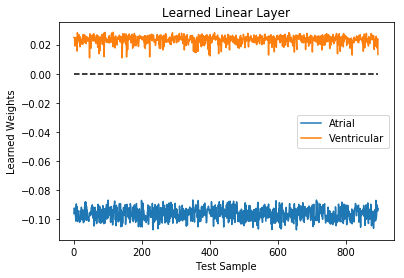

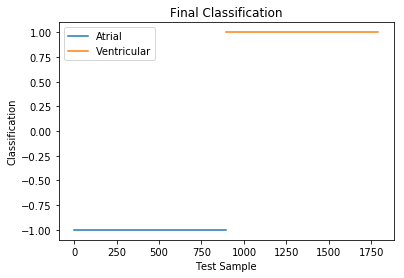

In [59]:
plt.figure()
y_a_pred=model(testingX[aTindice]).detach().numpy()
y_v_pred=model(testingX[vTindice]).detach().numpy()
plt.plot(y_a_pred)
plt.plot(y_v_pred)
plt.hlines(0,0,len(vTindice),colors='k',linestyles='dashed',label='Decision Boundary');
plt.legend(("Atrial", "Ventricular"))
plt.title('Learned Linear Layer')
plt.xlabel('Test Sample')
plt.ylabel('Learned Weights')

# -1 for atrial, +1 for ventricular
y_pred=model(testingX).detach().numpy()
y_pred[y_pred > 0] = 1
y_pred[y_pred < 0] = -1

plt.figure()
plt.plot(range(0,len(vTindice)),y_pred[y_pred<0])
plt.plot(range(len(vTindice),len(vTindice)*2),y_pred[y_pred>0])
plt.title('Final Classification')
plt.xlabel('Test Sample')
plt.legend(("Atrial","Ventricular"))
plt.ylabel('Classification')

nn_sum_test_acc=0

for i in range(0,len(ytest)-1):
  if y_pred[i]==ytest[i]:
    nn_sum_test_acc=nn_sum_test_acc+1

nn_test_acc=nn_sum_test_acc/len(ytest)

print("The accuracy of the neural network on the testing set is", nn_test_acc)

While the model is able to separate atrial and ventricular cells, it doesn't completely replicate the intended classification of Atrial cells = -1 and Ventricular cells = 1. The last step of the model is to take the sign filter (i.e. ceiling of the abs), after which we obtain the expected classifications.